## Rat flea model for Barcelona 1490

#### Import packages

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
#from pymc.Matplot import plot
import scipy.stats

#### Import observed data

In [2]:
london = np.array([2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 2, 4, 3, 4, 5, 5, 7, 9, 10, 11, 14, 14, 17, 17, 19, 20, 20, 21, 23, 23, 25, 27, 29, 30, 32, 35, 39, 41, 45, 49, 53, 57, 63, 67, 72, 78, 84, 89, 94, 100, 105, 110, 114, 118, 122, 128, 139, 150, 165, 184, 204, 226, 246, 261, 272, 279, 282, 281, 276, 275, 276, 282, 290, 303, 319, 337, 359, 381, 405, 431, 457, 486, 514, 538, 556, 569, 575, 577, 572, 565, 563, 572, 588, 616, 651, 696, 747, 797, 842, 882, 917, 947, 974, 994, 1008, 1015, 1014, 1007, 992, 970, 943, 924, 915, 916, 927, 948, 980, 1016, 1043, 1055, 1054, 1037, 1006, 961, 904, 854, 811, 775, 749, 730, 721, 716, 714, 711, 706, 701, 696, 689, 680, 668, 651, 628, 601, 568, 531, 488, 449, 411, 376, 344, 313, 287, 261, 238, 218, 199, 182, 169, 156, 146, 139, 138, 140, 145, 155, 169, 184, 199, 206, 211, 211, 206, 197, 183, 171, 159, 148, 138, 129, 122, 114, 107, 101, 93, 86, 79, 72, 64, 57, 52, 46, 41, 38, 36, 32, 31, 30, 29, 29, 29, 31, 31, 33, 33, 35, 36, 37, 38, 38, 38, 40, 40, 41, 41, 43])
mortality_data = london
t = len(mortality_data)

#### Set up the model

In [3]:
__all__ = [
    'S_r0', 'I_r0', 'R_r0', 'D_r0',
    'S_h0', 'I_h0', 'R_h0','D_h0',
    'H_f', 'S_r', 'I_r', 'R_r', 'D_r',
    'S_h', 'I_h', 'R_h', 'D_h'
    'human_mortality', 'rat_mortality',
    'mortality_sim']

#Parameters
beta_r = pm.Uniform('beta_r', 1e-9, 1.0, value = .08)
gamma = 0.2
sigma = 0.1
beta_h = pm.Uniform('beta_h', 1e-9, .2, value = .2)

sus_frac = pm.Uniform('sus_frac', 1e-9, 1.0, value = .14)
pop_size = 360000.

H_f0 = 6.0
I_f0 = 1.*H_f0

#Initial conditions for rat population
S_r0 = pop_size*sus_frac
I_r0 = pm.Uniform('I_r0', 1., 15., value=15.)
R_r0 = 0.
D_r0 = 0.

#Initial conditions for human population
S_h0 = 360000.
I_h0 = 1.*1.5
R_h0 = 0.
D_h0 = 1.

searching = 3./S_r0

#SIRD model for rat-flea palgue
@pm.deterministic 
def SIRD(H_f0=H_f0, I_f0=I_f0,
         S_r0=S_r0, I_r0=I_r0, R_r0=R_r0, D_r0=D_r0, 
         S_h0=S_h0, I_h0=I_h0, R_h0=R_h0, D_h0=D_h0,
         beta_r=beta_r, gamma=gamma, sigma=sigma, 
         searching=searching, beta_h=beta_h):
    
    H_f = np.zeros(t)
    I_f = np.zeros(t)

    S_r = np.zeros(t)
    I_r = np.zeros(t)
    R_r = np.zeros(t)
    D_r = np.zeros(t)

    S_h = np.zeros(t)
    I_h = np.zeros(t)
    R_h = np.zeros(t)
    D_h = np.zeros(t)
   
    H_f[0] = H_f0
    I_f[0] = I_f0
    
    S_r[0] = S_r0
    I_r[0] = I_r0
    R_r[0] = R_r0
    D_r[0] = D_r0

    S_h[0] = S_h0
    I_h[0] = I_h0
    R_h[0] = R_h0
    D_h[0] = D_h0

    for i in range(1,t):
        if i == 1: #Referenced before assignment at i = 1
            infected_rat_deaths=D_h0
            N_r = S_r[i-1]+I_r[i-1]+R_r[i-1]
           
        #Fleas
        K_f = H_f0 #avg number of fleas per rat at carrying capacity
        if H_f[i-1]/K_f < 1.:
            flea_growth = .0084*(H_f[i-1]*(1.-(H_f[i-1]/K_f)))
        elif H_f[i-1]/K_f > 1.:
            flea_growth = -.0084*(H_f[i-1]*(1.-(H_f[i-1]/K_f)))
        else:
            flea_growth = 0.
           
        new_infectious = infected_rat_deaths*(H_f[i-1])
        starvation_deaths = 0.2*I_f[i-1]
        force_to_humans = min(I_f[i-1], I_f[i-1]*np.exp(-searching*N_r)) #number of fleas that find a human
        force_to_rats = I_f[i-1]-force_to_humans #number of fleas that find a rat
       
        H_f[i] = H_f[i-1] + flea_growth
        I_f[i] = I_f[i-1] + new_infectious - starvation_deaths
       
        #Rats
        N_r = S_r[i-1]+I_r[i-1]+R_r[i-1]

        new_infected_rats = min(S_r[i-1], beta_r*S_r[i-1]*force_to_rats/N_r)
        new_removed_rats = gamma*I_r[i-1]
        new_recovered_rats = sigma*new_removed_rats
        new_dead_rats = new_removed_rats - new_recovered_rats
        infected_rat_deaths = new_dead_rats
       
        S_r[i] = S_r[i-1] - new_infected_rats 
        I_r[i] = I_r[i-1] + new_infected_rats - new_removed_rats 
        R_r[i] = R_r[i-1] + new_recovered_rats 
        D_r[i] = new_dead_rats
       
        #Humans
        N_h = S_h[i-1]+I_h[i-1]+R_h[i-1]
        
        new_infected_humans = min(S_h[i-1], beta_h*S_h[i-1]*force_to_humans/N_h)
        new_removed_humans = .1*I_h[i-1]
        new_recovered_humans = .4*new_removed_humans
        new_dead_humans = new_removed_humans - new_recovered_humans
        
        S_h[i] = S_h[i-1] - new_infected_humans
        I_h[i] = I_h[i-1] + new_infected_humans - new_removed_humans
        R_h[i] = R_h[i-1] + new_recovered_humans
        D_h[i] = new_dead_humans
       
    return H_f, I_f, S_r, I_r, R_r, D_r, I_h, D_h

D_h = pm.Lambda('D_h', lambda SIRD=SIRD: SIRD[7])

#Likelihood
mortality = pm.Poisson('mortality', mu=D_h, value=mortality_data, observed=True)
mortality_sim = pm.Poisson('mortality_sim', mu=D_h)

## Fitting with MCMC in pymc and graphing

In [4]:
if __name__ == '__main__':
    vars = [beta_r, gamma, sigma, searching,
    H_f0, I_r0, R_r0, D_r0, S_h0,
    I_h0, D_h0, D_h, beta_h,
    pop_size, sus_frac, mortality,
    mortality_data, mortality_sim]
    
    mc = pm.MCMC(vars, db='pickle', dbname='rat')
    mc.use_step_method(pm.AdaptiveMetropolis, [beta_r,beta_h, sus_frac, I_r0])
    mc.sample(iter=180000, burn=80000, thin=10, verbose=0)
    mc.sample(iter=180000, burn=80000, thin=10, verbose=0)
    mc.sample(iter=180000, burn=80000, thin=10, verbose=0)
    mc.db.close()

 [                  0%                  ] 1220 of 180000 complete in 4.5 sec

/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/pymc/StepMethods.py:1282: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)


 [-----------------100%-----------------] 180000 of 180000 complete in 524.2 sec

#### Output summary

In [ ]:
pm.gelman_rubin(mc)

In [5]:
mc.summary()

74            0.139                  [47. 79.]
	59.467           7.803            0.129                  [44. 74.]
	54.766           7.486            0.119                  [39. 68.]
	50.376           7.177            0.118                  [37. 64.]
	46.284           6.87             0.108                  [33. 59.]
	42.365           6.561            0.101                  [29. 54.]
	38.901           6.312            0.09                   [27. 51.]
	35.743           6.033            0.09                   [24. 47.]
	32.702           5.736            0.079                  [21. 43.]
	29.93            5.516            0.076                  [19. 40.]
	27.401           5.22             0.071                  [17. 37.]
	25.053           5.017            0.068                  [15. 34.]
	22.926           4.833            0.063                  [14. 32.]
	20.965           4.615            0.054                  [11. 29.]
	19.117           4.36             0.048                  [11. 27.]
	

In [10]:
mc.write_csv('rats.csv')

In [5]:
M = pm.MAP(mc)
M.fit()
M.BIC

56750.190023460964

#### Plot the posteriors

In [6]:
%matplotlib inline
plot(mc)

NameError: name 'plot' is not defined

#### Plot the fit

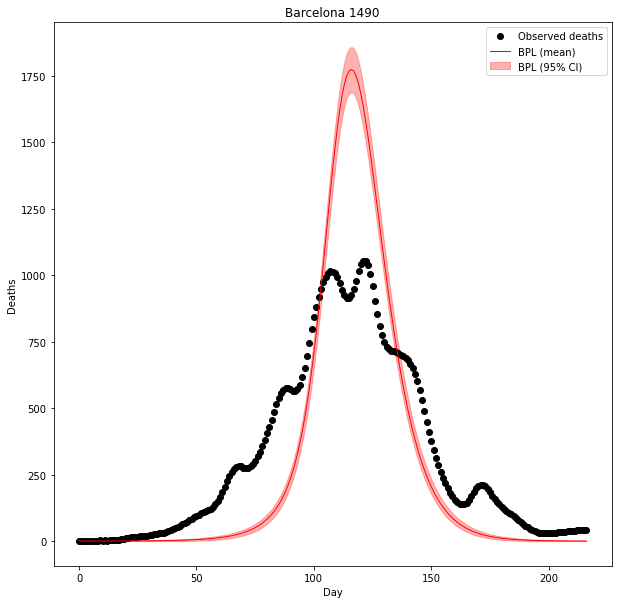

In [7]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.title('Barcelona 1490')
plt.xlabel('Day')
plt.ylabel('Deaths')
plt.plot(mortality_data, 'o', mec='black', color='black', label='Observed deaths')
plt.plot(mortality_sim.stats()['mean'], color='red', linewidth=1, label='BPL (mean)')
y_min = mortality_sim.stats()['quantiles'][2.5]
y_max = mortality_sim.stats()['quantiles'][97.5]
plt.fill_between(range(0,len(mortality_data)), y_min, y_max, color='r', alpha=0.3, label='BPL (95% CI)')
plt.legend()